In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split


In [2]:
df_train = pd.read_csv('../Dataset/kendaraan_train_clean.csv')
df_train.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.0,0.153846,1.0,0.634615,1.0,0.0,0.0,0.047251,0.932099,0.301038,0
1,1.0,0.430769,1.0,0.750000,0.0,2.0,1.0,0.043104,0.172840,0.512111,0
2,1.0,0.015385,1.0,0.884615,1.0,0.0,0.0,0.056002,0.981481,0.377163,0
3,0.0,0.584615,1.0,0.923077,0.0,1.0,0.0,0.000000,0.759259,0.183391,0
4,1.0,0.461538,1.0,0.673077,0.0,2.0,1.0,0.059953,0.537037,0.636678,0


In [3]:
def transform_data(df):
	X = df.drop('Tertarik', axis=1)
	y = df['Tertarik']

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	X_train = np.clip(np.array(X_train), -5, 5)
	X_test = np.clip(np.array(X_test), -5, 5)
	y_train = np.clip(np.array(y_train), -5, 5)
	y_test = np.clip(np.array(y_test), -5, 5)

	return X_train, X_test, y_train, y_test
 

def define_model(n_input):
	metrics = [
		keras.metrics.BinaryAccuracy(name='accuracy'),
		keras.metrics.Precision(name='precision'),
		keras.metrics.Recall(name='recall'),
		keras.metrics.AUC(name='auc'),
		keras.metrics.AUC(name='prc', curve='PR'),
	]

	model = Sequential()
	model.add(Dense(64, activation="relu", input_shape=(n_input,)))
	model.add(Dense(32, activation="relu"))
	model.add(Dropout(0.5)),
	model.add(Dense(1, activation='sigmoid'))

	model.compile(
		optimizer=keras.optimizers.Adam(learning_rate=1e-3),
		loss=BinaryCrossentropy(),
		metrics=metrics
	)

	return model


def calculate_class_weight(df):
	total = len(df)

	neg = len(df[df['Tertarik'] == 0])
	pos = len(df[df['Tertarik'] == 1])

	weight_for_0 = (1 / neg) * (total / 2.0)
	weight_for_1 = (1 / pos) * (total / 2.0)
	weights = {0: weight_for_0, 1: weight_for_1}

	return weights


EarlyStop = EarlyStopping(
    monitor='auc',
    patience=6,
    mode='max',
    restore_best_weights=True
)

trainX, trainy, testX, testy = transform_data(df_train)


### **Melatih Model Deep Learning** 

In [4]:
model = define_model(trainX.shape[1])

history = model.fit(
    trainX, testX,
    epochs=100,
    class_weight=calculate_class_weight(df_train),
    verbose=1,
    callbacks=EarlyStop,
    batch_size=128
)


Epoch 1/100
1786/1786 [==============================] - 5s 2ms/step - loss: 0.4608 - accuracy: 0.6519 - precision: 0.2523 - recall: 0.9440 - auc: 0.8220 - prc: 0.2939
Epoch 2/100
1786/1786 [==============================] - 3s 2ms/step - loss: 0.4471 - accuracy: 0.6675 - precision: 0.2614 - recall: 0.9448 - auc: 0.8308 - prc: 0.3054
Epoch 3/100
1786/1786 [==============================] - 3s 2ms/step - loss: 0.4445 - accuracy: 0.6749 - precision: 0.2652 - recall: 0.9400 - auc: 0.8344 - prc: 0.3115
Epoch 4/100
1786/1786 [==============================] - 3s 2ms/step - loss: 0.4439 - accuracy: 0.6764 - precision: 0.2658 - recall: 0.9374 - auc: 0.8358 - prc: 0.3162A: 2s - loss: 0.4456 - accuracy: 0.6739 - precision: 0.26
Epoch 5/100
1786/1786 [==============================] - 3s 2ms/step - loss: 0.4425 - accuracy: 0.6771 - precision: 0.2661 - recall: 0.9366 - auc: 0.8371 - prc: 0.3191
Epoch 6/100
1786/1786 [==============================] - 3s 2ms/step - loss: 0.4417 - accuracy: 0.6767 

### **Evaluasi Model**

In [6]:
def plot_cm(labels, predictions, p=0.5):
    predictions = model.predict(predictions)
    cm = confusion_matrix(labels, predictions > p)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d')

    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    return predictions

1786/1786 [==============================] - 3s 1ms/step - loss: 0.4877 - accuracy: 0.6709 - precision: 0.2687 - recall: 0.9540 - auc: 0.8492 - prc: 0.3529


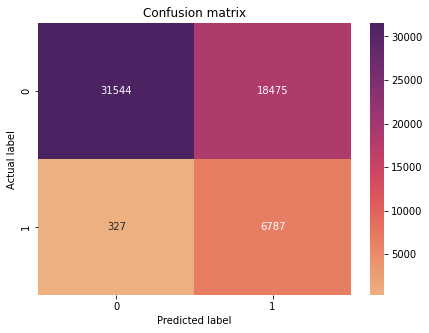

loss :  0.4877283275127411
accuracy :  0.6709082126617432
precision :  0.2686643898487091
recall :  0.9540342688560486
auc :  0.8492296934127808
prc :  0.3529033660888672
f1-score : 0.41926118112181865


In [7]:
baseline_results = model.evaluate(trainy, testy)
predictions = plot_cm(testy, trainy)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

print('f1-score :', f1_score(testy, predictions > 0.5))

### **Prediksi Dan Evaluasi Data Test**

In [8]:
df = pd.read_csv('../Dataset/kendaraan_test_clean.csv')
df.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0,0.446154,1,0.153846,0,1,1,0.082475,0.154321,0.467128,0
1,1,0.030769,1,0.903846,1,0,0,0.068822,0.932099,0.799308,0
2,1,0.061538,1,0.538462,1,0,0,0.200636,0.932099,0.179931,0
3,1,0.400000,1,0.153846,1,1,0,0.062575,0.759259,0.083045,0
4,1,0.230769,1,0.442308,0,1,1,0.045268,0.932099,0.757785,0


In [9]:
trainy = df.drop('Tertarik', axis=1)
testy = df['Tertarik']

1489/1489 [==============================] - 2s 2ms/step - loss: 0.4744 - accuracy: 0.6790 - precision: 0.2699 - recall: 0.9442 - auc: 0.8507 - prc: 0.3565


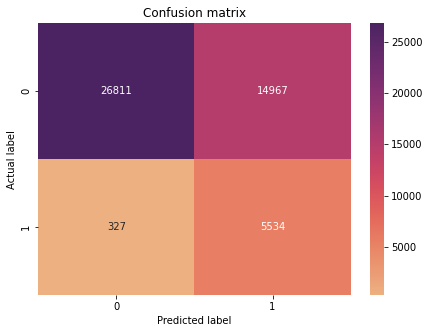

loss :  0.47435277700424194
accuracy :  0.6789605021476746
precision :  0.26993805170059204
recall :  0.944207489490509
auc :  0.8506543636322021
prc :  0.356477826833725
f1-score : 0.41984674910856534


In [13]:
baseline_test_results = model.evaluate(trainy, testy)
predictions = plot_cm(testy, trainy)

for name, value in zip(model.metrics_names, baseline_test_results):
  print(name, ': ', value)

print('f1-score :', f1_score(testy, predictions > 0.5))